### Verify that pytorch-geometric is correctly installed

If the notebook crashes at the import, there is likely an issue with the version of torch_geometric and torch_sparse being incompatible with the torch version.

In [1]:
## Verify that pytorch-geometric is correctly installed
import torch
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing
import numpy as np

## Load model
This steps takes a few minutes for the model to download.

**UPDATE**: It is important to set the model in eval mode through `model = model.eval()` to disable random dropout for optimal performance.

In [2]:
import esm
model, alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
model = model.to('cuda')
model = model.eval()

#google how to transfer model onto gpu
#something like model = model.to('cuda')

/home/gkannan/anaconda3/envs/inverse-test/lib/python3.9/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [13]:
!nvidia-smi

Wed Aug 31 20:32:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:01:00.0 Off |                    0 |
|  0%   43C    P0    78W / 300W |   1351MiB / 45634MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          On   | 00000000:43:00.0 Off |                    0 |
|  0%   

## Load structure from PDB or CIF files


In [ ]:
!wget https://files.rcsb.org/download/6VXX.pdb -P data/    # save this to the data folder in colab

Load chain from PDB file:

In [3]:
fpath = 'data/6M0J.pdb' # .pdb format is also acceptable
chain_id = 'E'
structure = esm.inverse_folding.util.load_structure(fpath, chain_id)
coords, native_seq = esm.inverse_folding.util.extract_coords_from_structure(structure)
print('Native sequence:')
print(native_seq)
print(len(native_seq))

Native sequence:
TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG
194


## Calculate all possible mutations in a protein

To do this, we define the 'template' sequence - the full sequence of what we want to analyze. For example, this can be the SARS-CoV-2 spike. Then, we define the 'mutating' sequence - the section of that that we want to mutate. This could be the RBD. If both are the same, we mutate and analyze the full RBD.

In [1]:
#Calculating all possible mutants in protein

#RBD:
wuhan = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
alpha = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'
delta = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'
beta = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'
eta = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
N460K = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSKLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
N460A = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSALKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
N460W = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSWLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
V433R = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCRIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
V433T = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCTIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
N501R = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTRGVGYQPYRVVVLSFELLHAPATVCG'
N501A = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTAGVGYQPYRVVVLSFELLHAPATVCG'
E471R = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTRIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
S477N = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGNTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'

wt_6vxx_spike = 'AYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVNCTFEYVSFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKGNYNYLYRKPFERDIYFPLQSYGFQPTNVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTSQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDPPEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDS'
wt_6vxx_ntd = 'AYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVNCTFEYVSFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQT'

## Why am I not using the full RBD/spike/etc.? The model won't allow me - it only takes into account lengths if they match the native sequence in the pdb.


chosenseq = alpha  #The template sequence - i.e. if you want to run full spike but mutate RBD, this is full spike.
chosenseqname = 'alpha'  
choosemutseq = alpha   #The sequence you want to mutate - for example, RBD in full spike
startpoint = 0   #The AA residue (indexed at 0) that the mutated sequence starts at in template.
true_index = 333 #The true start of the sequence in the FL spike protein; for RBD this is 333, for NTD this is 14
likelihoodorlog = 'likelihood' #Use likelihood or log likelihood for analysis
multichain = True
bindingorexpression = 'binding'

seq = list(chosenseq)
aalist = ["A","R","N","D","C","E","Q","G","H","I","L","K","M","F","P","S","T","W","Y","V"]

seq2 = seq.copy()
muts = {'WT': "".join(seq)}

for i in range(startpoint,startpoint+len(choosemutseq)):
  for j in aalist:
    seq2[i] = j
    muts.update({str(i)+j:"".join(seq2)})
    seq2 = seq.copy()


In [5]:
#Saving in /data folder

output_path = 'data/all_mutant_list_'+chosenseqname+'.txt'
output_file = open(output_path,'w')

for seq_id, sequence in muts.items():
    identifier_line = ">" + seq_id + "\n"
    output_file.write(identifier_line)
    sequence_line = sequence + "\n"
    output_file.write(sequence_line)
    
#Close the file when we're done
output_file.close()

## Conditional sequence log-likelihoods for given backbone coordinates

The log-likelihood scores could be used to predict mutational effects. See also our [script](https://github.com/facebookresearch/esm/tree/main/examples/inverse_folding#scoring-sequences) for batch scoring,

In [7]:
mutantlistname = 'data/all_mutant_list_'+chosenseqname+'.txt'
ll_list_name = 'data/mutant_list_lls_N501Y_mc.csv'

!python score_log_likelihoods2.py data/6M0J.pdb \
    $mutantlistname --chain E --multichain-backbone\
    --outpath $ll_list_name

/home/gkannan/anaconda3/envs/inverse-test/lib/python3.9/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(
Native sequence loaded from structure file:
TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG


Native sequence
Log likelihood: -1.21
Perplexity: 3.35

Scoring variant sequences from sequence file..

100%|███████████████████████████████████████| 3881/3881 [32:41<00:00,  1.98it/s]
Results saved to data/mutant_list_lls_N501Y_mc.csv


## Analysis

At this point we have all mutations & the associated log-likelihood outputs from the model.

In [68]:
#Read in data, make new dataframes

import pandas as pd
import numpy as np

aalist = ["A","R","N","D","C","E","Q","G","H","I","L","K","M","F","P","S","T","W","Y","V"]

#Read in data as dataframe

all_mutants_df=pd.read_table("data/all_mutant_list.txt", sep=" ", header=None)
all_mutants_N501Y_df=data=pd.read_table("data/all_mutant_list_N501Y_mc.txt", sep=" ", header=None)
all_mutants_df.insert(1,'sequence','')
all_mutants_N501Y_df.insert(1,'sequence','')
all_mutants_delta_df=pd.read_table("data/all_mutant_list_delta.txt", sep=" ", header=None)
all_mutants_delta_df.insert(1,'sequence','')

#Split dataframe into mutation & sequence

mutants_df = pd.DataFrame({'mutation':all_mutants_df[0].iloc[::2].values, 'sequence':all_mutants_df[0].iloc[1::2].values})
N501Y_df = pd.DataFrame({'mutation':all_mutants_N501Y_df[0].iloc[::2].values, 'sequence':all_mutants_N501Y_df[0].iloc[1::2].values})
delta_df = pd.DataFrame({'mutation':all_mutants_delta_df[0].iloc[::2].values, 'sequence':all_mutants_delta_df[0].iloc[1::2].values})

#Read in mutation & log likelihood

mlistll=pd.read_csv("data/mutant_list_lls_mc.csv", sep=",", header=0)
mlistN501Yll=data=pd.read_csv("data/mutant_list_llsN501Y_mc.csv", sep=",", header=0)
mlistdeltall=data=pd.read_csv("data/mutant_list_lls_delta.csv", sep=",", header=0)


In [69]:
#Add likelihoods to main dataframes, and normalize

mutants_df['log likelihood'] = mlistll['log_likelihood']
N501Y_df['log likelihood'] = mlistN501Yll['log_likelihood']
delta_df['log likelihood'] = mlistdeltall['log_likelihood']

mutants_df['likelihood'] = np.exp(mutants_df['log likelihood'])# -np.exp(-1.1953586339950562) #Centers them around 0 = basis sequence
N501Y_df['likelihood'] = np.exp(N501Y_df['log likelihood'])# -np.exp(-1.2073875665664673)
delta_df['likelihood'] = np.exp(delta_df['log likelihood'])# -np.exp(-1.2177070379257202)

In [70]:
### See how model computes log likelihood

In [71]:
#Distance metric

N501Y_df['ll_ratio'] = (N501Y_df['log likelihood'] - -1.2073875665664673) - (mutants_df['log likelihood'] - -1.1953586339950562)
delta_df['ll_ratio'] = (delta_df['log likelihood'] - -1.2177070379257202) - (mutants_df['log likelihood'] - -1.1953586339950562)



<AxesSubplot:>

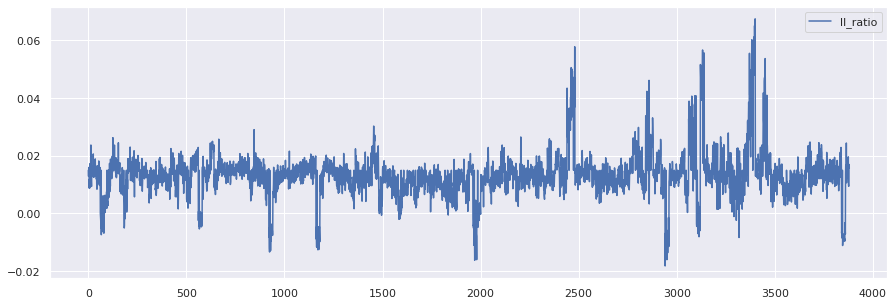

In [72]:
#Plot ratio as is

delta_df.plot(y='ll_ratio')

In [73]:
#Split > off of mutation
N501Y_df['mutation'] = N501Y_df['mutation'].map(lambda x: x.lstrip('>'))
mutants_df['mutation'] = mutants_df['mutation'].map(lambda x: x.lstrip('>'))
delta_df['mutation'] = delta_df['mutation'].map(lambda x: x.lstrip('>'))

#Copy mutation to column index

N501Y_df['index']=N501Y_df['mutation']
mutants_df['index']=mutants_df['mutation']
delta_df['index']=delta_df['mutation']

#Remove wild type sequence (first one)

N501Y_df_noWT = N501Y_df.copy()
N501Y_df_noWT = N501Y_df_noWT.iloc[1: , :]

mutants_df_noWT = mutants_df.copy()
mutants_df_noWT = mutants_df_noWT.iloc[1: , :]

delta_df_noWT = delta_df.copy()
delta_df_noWT = delta_df_noWT.iloc[1: , :]

#Remove index from mutation column, and amino acid from index column.
#This gives us one column defining index & one column defining the amino acid at that position.

N501Y_df_noWT['mutation'] = N501Y_df_noWT['mutation'].str.replace('\d+', '')
N501Y_df_noWT['index'] = N501Y_df_noWT['index'].str.replace(str(aalist), '')

mutants_df_noWT['mutation'] = mutants_df_noWT['mutation'].str.replace('\d+', '')
mutants_df_noWT['index'] = mutants_df_noWT['index'].str.replace(str(aalist), '')

delta_df_noWT['mutation'] = delta_df_noWT['mutation'].str.replace('\d+', '')
delta_df_noWT['index'] = delta_df_noWT['index'].str.replace(str(aalist), '')

/tmp/ipykernel_1055435/100052836.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  N501Y_df_noWT['mutation'] = N501Y_df_noWT['mutation'].str.replace('\d+', '')
/tmp/ipykernel_1055435/100052836.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  N501Y_df_noWT['index'] = N501Y_df_noWT['index'].str.replace(str(aalist), '')
/tmp/ipykernel_1055435/100052836.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  mutants_df_noWT['mutation'] = mutants_df_noWT['mutation'].str.replace('\d+', '')
/tmp/ipykernel_1055435/100052836.py:30: FutureWarning: The default value of regex will change from True to False in a future version.
  mutants_df_noWT['index'] = mutants_df_noWT['index'].str.replace(str(aalist), '')
/tmp/ipykernel_1055435/100052836.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  delt

In [74]:
#Shift index to true index; i.e. change position 0 to position 333 for RBD.

true_index = 333

N501Y_df_noWT['index'] = pd.to_numeric(N501Y_df_noWT['index'])
N501Y_df_noWT['index'] = N501Y_df_noWT['index'] + true_index

delta_df_noWT['index'] = pd.to_numeric(delta_df_noWT['index'])
delta_df_noWT['index'] = delta_df_noWT['index'] + true_index

#result here is a pivot table of ll_ratio, other pivot tables are of just likelihood

result = N501Y_df_noWT.pivot_table(index='mutation', columns='index', values='ll_ratio',sort=False)

mutants_df_noWT['index'] = pd.to_numeric(mutants_df_noWT['index'])
mutants_df_noWT['index'] = mutants_df_noWT['index'] + true_index

#Create a pivot table w/ index on x and mutation on y

result_mut = mutants_df_noWT.pivot_table(index='mutation', columns='index', values='likelihood',sort=False)

result_N501Y = N501Y_df_noWT.pivot_table(index='mutation', columns='index', values='likelihood',sort=False)

result_delta = delta_df_noWT.pivot_table(index='mutation', columns='index', values='ll_ratio',sort=False)

result_delta_only = delta_df_noWT.pivot_table(index='mutation', columns='index', values='likelihood',sort=False)

In [75]:
#Normalize columns to 1

#for column in result_N501Y:
#    result_N501Y[column] = result_N501Y[column]/result_N501Y[column].sum()

#for column in result_mut:
#    result_mut[column] = result_mut[column]/result_mut[column].sum()


In [76]:
#Ship to excel

result_delta.to_excel('data/result_delta.xlsx')

# Comparing Alpha (N501Y) and Wuhan

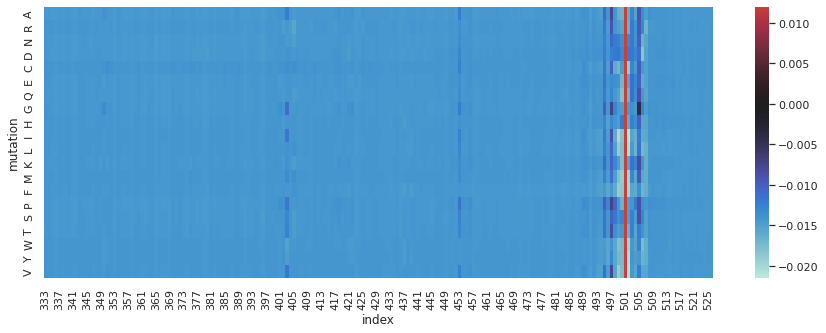

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result, annot=False, cmap='icefire',center=0)
plt.show()

#Heatmap of ll_ratio

In [78]:
#### NA THE 501 POSITION ABOVE

### Ian Wilson group Nat Comm Flu epistasis deep mutational scanning 2020 7 diff flu-HA backgrounds all possible amino acid changes at like 6 sites

### make sure i'm using gpu compute lmao

### Figure out if JSD is using softmax to make it probabilities -> making it jensen shannon

<AxesSubplot:xlabel='index'>

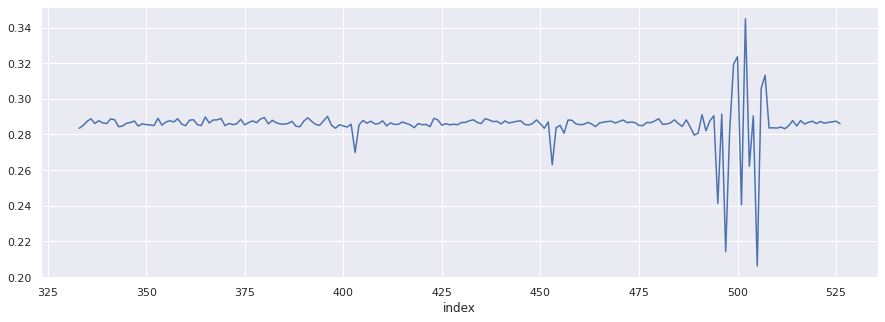

In [79]:
#Quick & dirty quantification - vertical sum of absolute values of heatmap

result_abs = abs(result)
resultsum = result_abs.sum()
resultsum.plot()

# Wuhan/Variants Heatmaps

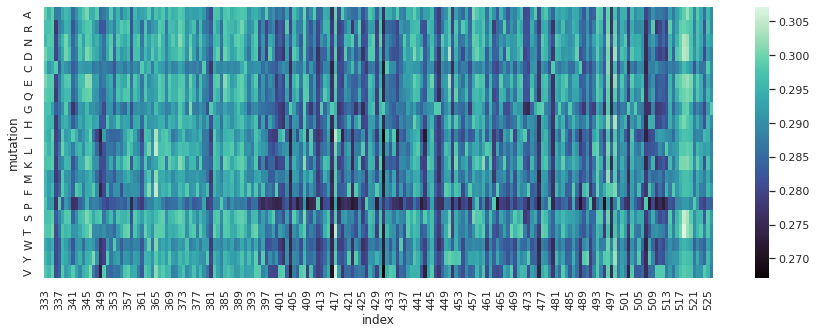

In [80]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_mut, annot=False, cmap='mako')
plt.show()
#Wuhan

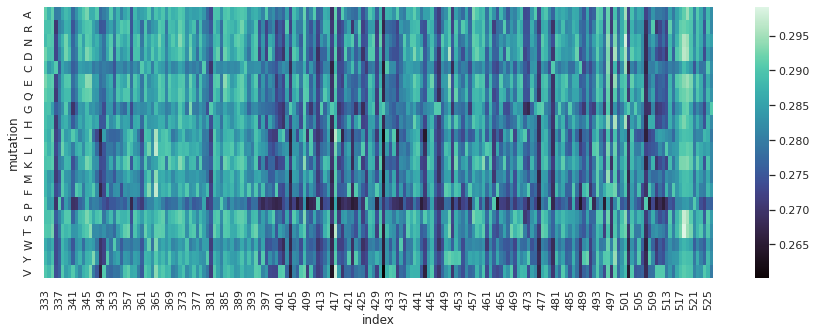

In [81]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_N501Y, annot=False, cmap='mako')
plt.show()
#N501Y

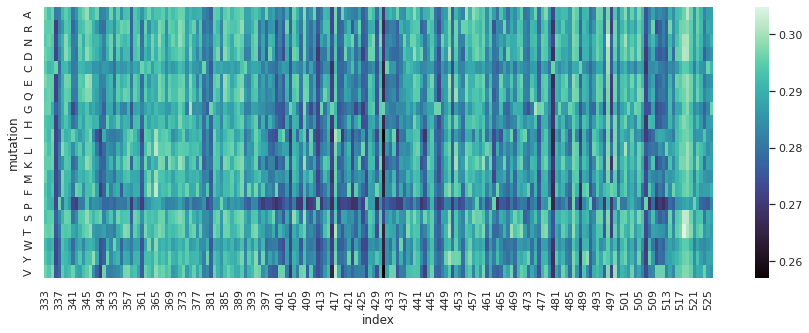

In [82]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_delta_only, annot=False, cmap='mako')
plt.show()
#Delta

# Bloom Data

In [83]:
#Let's try a Spearman correlation with the JB expression data.

#First, let's import the data and separate it into dataframes for each variant.

jb_df = pd.read_csv('data/bloom_science_expr.csv')

In [84]:
#create unique list of names
VariantNames = jb_df.target.unique()

#create a data frame dictionary to store the data frames
bloom_data = {elem : pd.DataFrame() for elem in VariantNames}

for key in bloom_data.keys():
    bloom_data[key] = jb_df[:][jb_df.target == key]

In [85]:
#Pivot table to get each variant
bloom_N501Y = bloom_data['N501Y'].pivot_table(index='mutant', columns='position', values='delta_bind',sort=False)
bloom_wuhan = bloom_data['Wuhan-Hu-1'].pivot_table(index='mutant', columns='position', values='delta_bind',sort=False)
bloom_delta = bloom_data['Delta'].pivot_table(index='mutant', columns='position', values='delta_bind',sort=False)

#Drop the first two columns and last five columns; these are cut out in the native sequence for esm-if1.
bloom_N501Y = bloom_N501Y.iloc[: , 2:196]
bloom_wuhan = bloom_wuhan.iloc[: , 2:196]
bloom_delta = bloom_delta.iloc[: , 2:196]


In [86]:
bloom_data['N501Y']

,target,wildtype,position,mutant,mutation,bind,delta_bind,n_bc_bind,n_libs_bind,bind_rep1,bind_rep2,bind_rep3,expr,delta_expr,n_bc_expr,n_libs_expr,expr_rep1,expr_rep2
8040,N501Y,N,331,A,N331A,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
8041,N501Y,N,331,C,N331C,9.59284,-0.36219,13,3,9.63199,9.57676,9.56977,9.58908,-0.55522,9,2,9.66335,9.51482
8042,N501Y,N,331,D,N331D,9.86832,-0.08671,10,3,9.77909,9.78857,10.03729,10.07589,-0.06841,8,2,9.91359,10.23819
8043,N501Y,N,331,E,N331E,9.92660,-0.02208,1,1,NaN,9.92660,NaN,10.13296,-0.01134,2,2,10.32345,9.94246
8044,N501Y,N,331,F,N331F,9.58949,-0.36872,4,2,9.50579,NaN,9.67318,9.52710,-0.58089,2,1,9.52710,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12055,N501Y,T,531,S,T531S,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
12056,N501Y,T,531,T,T531T,9.95503,0.00000,23788,3,9.88468,9.94868,10.03172,10.14430,0.00000,21054,2,10.10799,10.18061
12057,N501Y,T,531,V,T531V,10.56670,0.53498,1,1,NaN,NaN,10.56670,10.20020,0.09221,1,1,10.20020,NaN
12058,N501Y,T,531,W,T531W,9.92021,-0.02847,1,1,NaN,9.92021,NaN,10.16400,-0.01662,1,1,NaN,10.16400


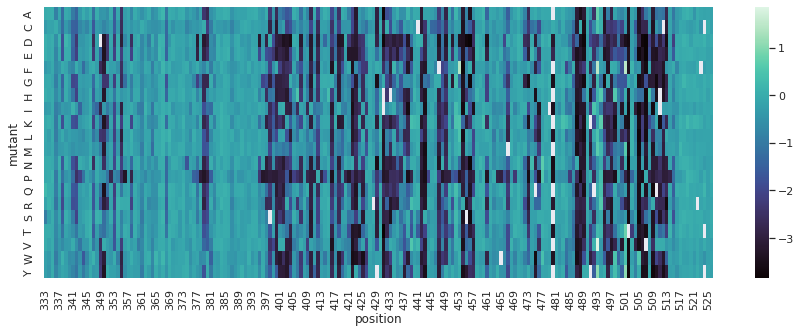

In [87]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(bloom_wuhan, annot=False, cmap='mako')
plt.show()
#wuhan

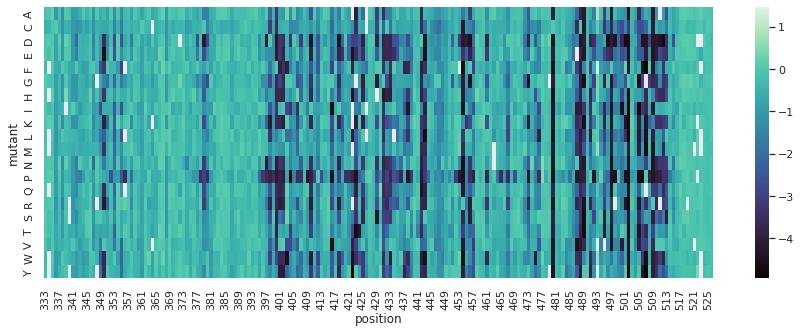

In [88]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(bloom_N501Y, annot=False, cmap='mako')
plt.show()
#N501Y

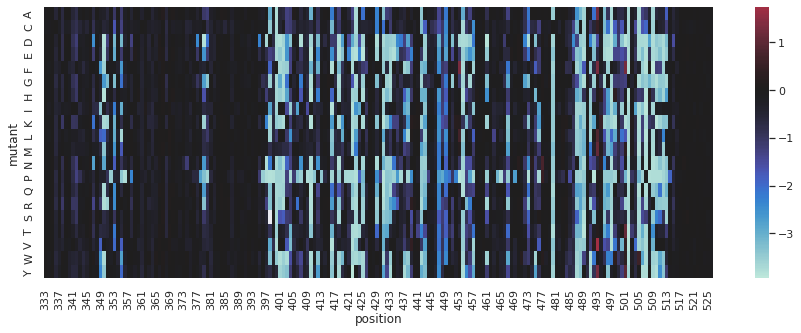

In [89]:
sns.set(rc = {'figure.figsize':(15,5)})

cmaptest = sns.diverging_palette(240, 0, s=100, sep=1 ,l=70, center='dark',as_cmap=True)

sns.heatmap(bloom_delta, annot=False, cmap='icefire',center=0)
plt.show()
#delta

In [90]:
#Now to actually try a spearman correlation; we need to put all the bloom delta expression and my data in one column each.

N501Y_df_noWT_rn = N501Y_df_noWT.copy()
N501Y_df_noWT_rn = N501Y_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})

N501Y_df_noWT_rn = N501Y_df_noWT.copy()
N501Y_df_noWT_rn = N501Y_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})

N501Y_merged_df = N501Y_df_noWT_rn.merge(bloom_data['N501Y'],on = ['position', 'mutant'], how = 'left')

In [91]:
#All the same data processing for delta

delta_df_noWT_rn = delta_df_noWT.copy()
delta_df_noWT_rn = delta_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})
delta_merged_df = delta_df_noWT_rn.merge(bloom_data['Delta'],on = ['position', 'mutant'], how = 'left')


In [92]:
#Now the actual spearman correlation


corr_columns_N501Y = N501Y_merged_df[['likelihood','delta_expr']]

corr_columns_delta = delta_merged_df[['likelihood','expr']]


N501Y expression correlation

In [93]:
corr_columns_N501Y.corr(method='spearman')

,likelihood,delta_expr
likelihood,1.000000,0.647936
delta_expr,0.647936,1.000000


<AxesSubplot:xlabel='likelihood'>

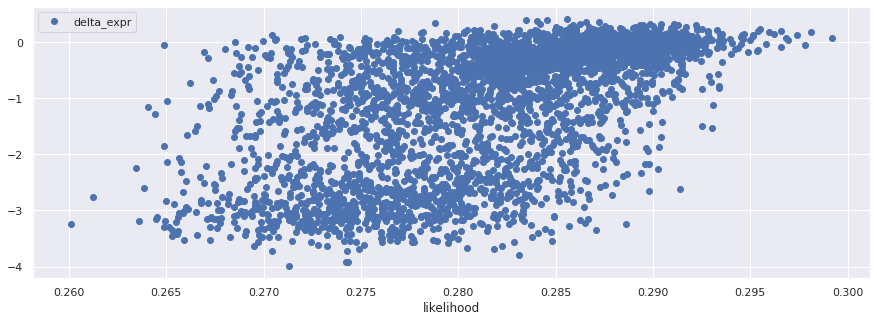

In [94]:
corr_columns_N501Y.plot(x='likelihood',y='delta_expr',style='o')

Delta expression correlation

In [95]:
corr_columns_delta.corr(method='spearman')

,likelihood,expr
likelihood,1.00000,0.65381
expr,0.65381,1.00000


<AxesSubplot:xlabel='likelihood'>

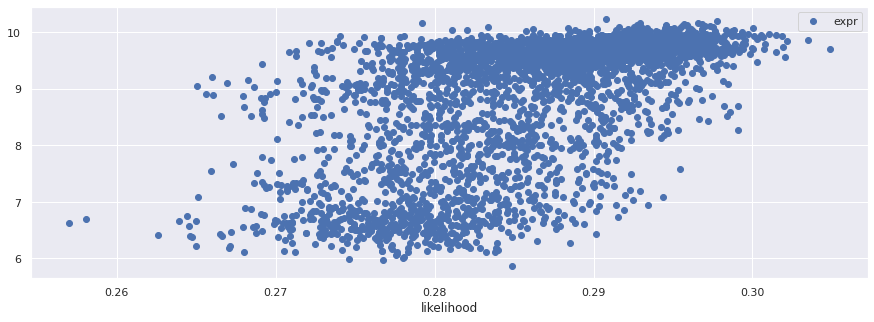

In [96]:
corr_columns_delta.plot(x='likelihood',y='expr',style='o')

Correlation for binding

In [97]:
corr_columns_N501Y_bind = N501Y_merged_df[['likelihood','bind']]
corr_columns_N501Y_bind.corr(method='spearman')

,likelihood,bind
likelihood,1.000000,0.689207
bind,0.689207,1.000000


In [98]:
corr_columns_delta_bind = delta_merged_df[['likelihood','bind']]
corr_columns_delta_bind.corr(method='spearman')

,likelihood,bind
likelihood,1.000000,0.621878
bind,0.621878,1.000000


In [99]:
#Put bloom data as expr_ratio on same metric that we did for ESM outputs

bloom_data_N501Y_expr = bloom_data['N501Y'][['position','mutant','expr']]
bloom_data_N501Y_expr['expr_ratio'] = np.log(bloom_data['N501Y']['expr'].to_numpy()/10.14430) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)


/tmp/ipykernel_1055435/1383603678.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bloom_data_N501Y_expr['expr_ratio'] = np.log(bloom_data['N501Y']['expr'].to_numpy()/10.14430) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)


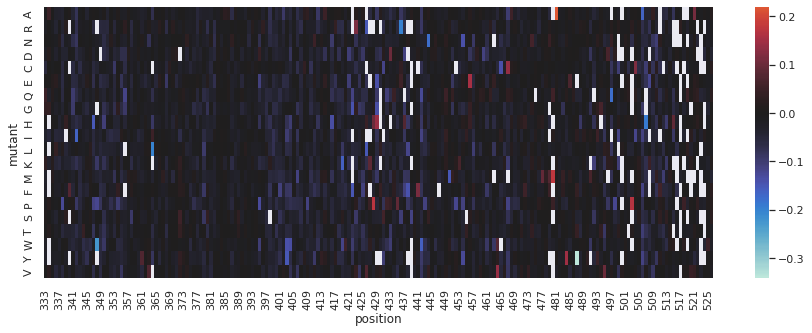

In [100]:
#Actual comparison for N501Y with same metric

N501Y_merged_df_2 = N501Y_df_noWT_rn.merge(bloom_data_N501Y_expr,on = ['position', 'mutant'], how = 'left')


bloom_pivot_N501Y = N501Y_merged_df_2.pivot_table(index='mutant', columns='position', values='expr_ratio',sort=False)

sns.heatmap(bloom_pivot_N501Y, annot=False, cmap='icefire',center=0)
plt.show()


<AxesSubplot:xlabel='position'>

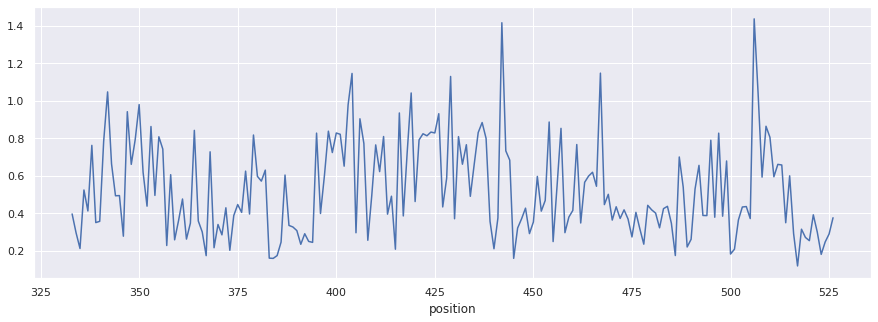

In [101]:
#Vertical sum for bloom data N501Y comparison
bloom_pivot_N501Y_abs = abs(bloom_pivot_N501Y)
bloom_pivot_N501Y_sum = bloom_pivot_N501Y_abs.sum()
bloom_pivot_N501Y_sum.plot()

In [102]:
N501Y_df_noWT_rn = N501Y_df_noWT.copy()
N501Y_df_noWT_rn = N501Y_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})
N501Y_merged_df = N501Y_df_noWT_rn.merge(bloom_data_N501Y_expr,on = ['position', 'mutant'], how = 'left')

Correlating the epistatic shifts w/ both operated on the same way.

In [103]:
corr_columns_N501Y_expr_ratio = N501Y_merged_df[['ll_ratio','expr_ratio']]
corr_columns_N501Y_expr_ratio.corr(method='spearman')

,ll_ratio,expr_ratio
ll_ratio,1.000000,0.002421
expr_ratio,0.002421,1.000000


<AxesSubplot:xlabel='ll_ratio'>

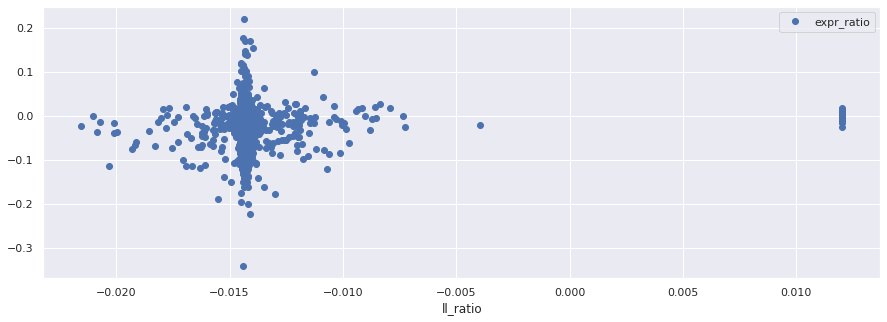

In [104]:
corr_columns_N501Y_expr_ratio.plot(x='ll_ratio',y='expr_ratio',style='o')

In [105]:
#Going through the same process for Delta

bloom_data_Delta_expr = bloom_data['Delta'][['position','mutant','expr']]
bloom_data_Delta_expr['expr_ratio'] = np.log(bloom_data['Delta']['expr'].to_numpy()/9.79026) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)

delta_df_noWT_rn = delta_df_noWT_rn.copy()
delta_df_noWT_rn = delta_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})
Delta_merged_df = delta_df_noWT_rn.merge(bloom_data_Delta_expr,on = ['position', 'mutant'], how = 'left')

corr_columns_Delta_expr_ratio = Delta_merged_df[['ll_ratio','expr_ratio']]
corr_columns_Delta_expr_ratio.corr(method='spearman')

/tmp/ipykernel_1055435/3595949502.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bloom_data_Delta_expr['expr_ratio'] = np.log(bloom_data['Delta']['expr'].to_numpy()/9.79026) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)


,ll_ratio,expr_ratio
ll_ratio,1.000000,0.092753
expr_ratio,0.092753,1.000000


Jensen-shannon divergence

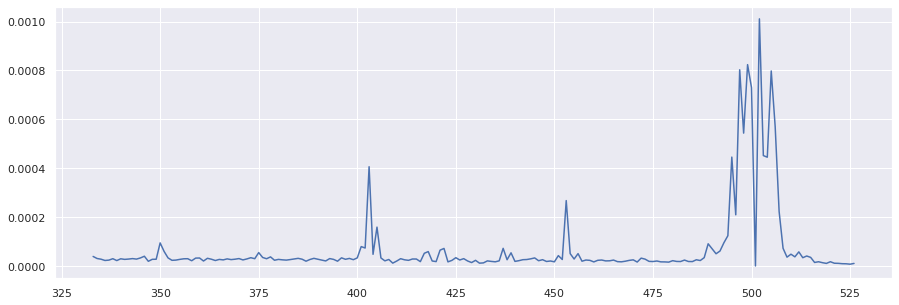

In [106]:
#Cycle through all positions, calculate JSD between results_N501Y and result_mutant at each position
import scipy

jsd_N501Y = []
columns=[]

for column in result_N501Y:
    columns.append(column)
    jsd_N501Y.append(scipy.spatial.distance.jensenshannon(result_N501Y[column],result_mut[column]))
    
plt.plot(columns,jsd_N501Y)

In [107]:
result_mut_prob = result_mut.copy()
for column in result_mut_prob:
    colsum = np.exp(-np.log(result_mut_prob[column])).sum()
    result_mut_prob = result_mut_prob.applymap(lambda x: (np.exp(-np.log(x)))/colsum)

result_N501Y_prob = result_N501Y.copy()
for column in result_N501Y_prob:
    colsum = np.exp(-np.log(result_N501Y_prob[column])).sum()
    result_N501Y_prob = result_N501Y_prob.applymap(lambda x: (np.exp(-np.log(x)))/colsum)

    
print(result_mut_prob[498])
print(result_N501Y_prob[498])
#x = result_mut[498]
#y = result_N501Y[498]
#x = (x - x.min())/(x.max()-x.min())
#y = (y - y.min())/(y.max()-y.min())

mutation
A    0.051212
R    0.051598
N    0.051777
D    0.052185
C    0.051123
E    0.052060
Q    0.051456
G    0.050134
H    0.052337
I    0.051320
L    0.051763
K    0.051430
M    0.051479
F    0.051893
P    0.049704
S    0.051146
T    0.051338
W    0.051852
Y    0.052213
V    0.051630
Name: 498, dtype: float64
mutation
A    0.051221
R    0.051597
N    0.051895
D    0.052301
C    0.051029
E    0.052094
Q    0.051453
G    0.050207
H    0.052346
I    0.051233
L    0.051724
K    0.051488
M    0.051451
F    0.051799
P    0.049883
S    0.051268
T    0.051372
W    0.051782
Y    0.052140
V    0.051572
Name: 498, dtype: float64


In [108]:
print(result_mut_prob[498])
print(result_N501Y_prob[498])

mutation
A    0.051212
R    0.051598
N    0.051777
D    0.052185
C    0.051123
E    0.052060
Q    0.051456
G    0.050134
H    0.052337
I    0.051320
L    0.051763
K    0.051430
M    0.051479
F    0.051893
P    0.049704
S    0.051146
T    0.051338
W    0.051852
Y    0.052213
V    0.051630
Name: 498, dtype: float64
mutation
A    0.051221
R    0.051597
N    0.051895
D    0.052301
C    0.051029
E    0.052094
Q    0.051453
G    0.050207
H    0.052346
I    0.051233
L    0.051724
K    0.051488
M    0.051451
F    0.051799
P    0.049883
S    0.051268
T    0.051372
W    0.051782
Y    0.052140
V    0.051572
Name: 498, dtype: float64


In [109]:
scipy.spatial.distance.jensenshannon(result_mut_prob[498],result_N501Y_prob[498])

0.0005435731150238662

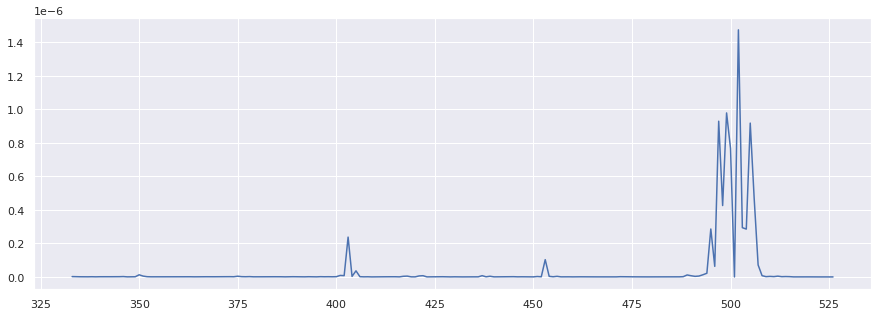

In [110]:
#!/usr/bin/env python
from scipy.stats import entropy
from numpy.linalg import norm
import numpy as np

# calculate the kl divergence
def kl_divergence(p, q):
    return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)))

def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (kl_divergence(_P, _M) + kl_divergence(_Q, _M))

jsd_N501Y = []
columns=[]

for column in result_N501Y:
    columns.append(column)
    jsd_N501Y.append(JSD(result_N501Y[column],result_mut[column]))
    
plt.plot(columns,jsd_N501Y)


In [111]:
result_N501Y

index,333,334,335,336,337,338,339,340,341,342,...,517,518,519,520,521,522,523,524,525,526
mutation,,,,,,,,,,,,,,,,,,,,,
A,0.291489,0.287555,0.291144,0.279920,0.280259,0.285730,0.288404,0.286878,0.277739,0.282792,...,0.288415,0.291299,0.294580,0.290356,0.281526,0.290356,0.285841,0.278297,0.287971,0.282510
R,0.289502,0.289377,0.290665,0.270629,0.280584,0.282640,0.287085,0.286452,0.274908,0.280499,...,0.291133,0.291797,0.290867,0.289891,0.280598,0.289558,0.286538,0.274990,0.289277,0.281722
N,0.288697,0.290356,0.290184,0.272690,0.283043,0.287555,0.292192,0.287198,0.277356,0.282379,...,0.292041,0.295973,0.294653,0.289589,0.281870,0.289529,0.285998,0.277295,0.286844,0.284801
D,0.292229,0.289363,0.289671,0.272633,0.280587,0.285793,0.292197,0.289107,0.277929,0.280030,...,0.292066,0.296547,0.295477,0.289747,0.283088,0.289049,0.284882,0.273447,0.284431,0.281170
C,0.290225,0.283790,0.286206,0.290356,0.275937,0.285483,0.283255,0.281814,0.275995,0.277759,...,0.284033,0.288543,0.286098,0.283894,0.274915,0.284455,0.278996,0.279137,0.290356,0.282561
E,0.292833,0.290409,0.291050,0.272514,0.279606,0.286597,0.290232,0.290356,0.278129,0.281703,...,0.291672,0.293479,0.294608,0.292753,0.284180,0.290810,0.286647,0.277017,0.286613,0.281543
Q,0.291268,0.290011,0.290326,0.271055,0.280142,0.286685,0.288572,0.288520,0.276770,0.279937,...,0.291282,0.291945,0.292942,0.291793,0.282296,0.289955,0.286575,0.278105,0.288223,0.283117
G,0.289413,0.289528,0.284956,0.275922,0.278968,0.282965,0.290356,0.281578,0.270012,0.275915,...,0.284916,0.291083,0.291639,0.285481,0.277097,0.281697,0.278828,0.272883,0.284066,0.290356
H,0.289341,0.287722,0.288272,0.270773,0.279027,0.286009,0.287248,0.283413,0.275826,0.280538,...,0.290520,0.292646,0.290356,0.288527,0.280783,0.286676,0.282180,0.274531,0.287636,0.281934


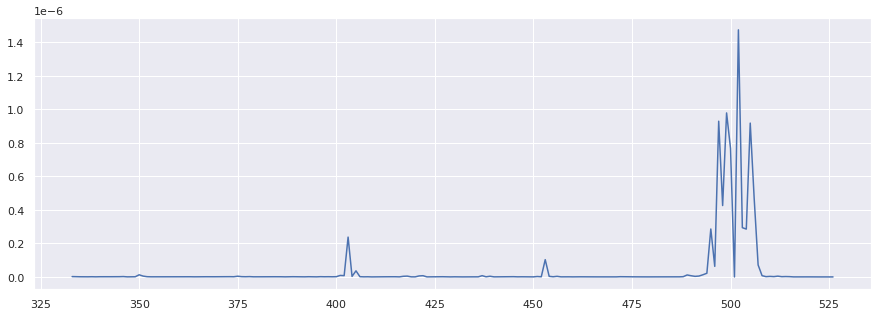

In [112]:
plt.plot(columns,jsd_N501Y)

In [113]:
bloom_data['N501Y']

,target,wildtype,position,mutant,mutation,bind,delta_bind,n_bc_bind,n_libs_bind,bind_rep1,bind_rep2,bind_rep3,expr,delta_expr,n_bc_expr,n_libs_expr,expr_rep1,expr_rep2
8040,N501Y,N,331,A,N331A,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
8041,N501Y,N,331,C,N331C,9.59284,-0.36219,13,3,9.63199,9.57676,9.56977,9.58908,-0.55522,9,2,9.66335,9.51482
8042,N501Y,N,331,D,N331D,9.86832,-0.08671,10,3,9.77909,9.78857,10.03729,10.07589,-0.06841,8,2,9.91359,10.23819
8043,N501Y,N,331,E,N331E,9.92660,-0.02208,1,1,NaN,9.92660,NaN,10.13296,-0.01134,2,2,10.32345,9.94246
8044,N501Y,N,331,F,N331F,9.58949,-0.36872,4,2,9.50579,NaN,9.67318,9.52710,-0.58089,2,1,9.52710,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12055,N501Y,T,531,S,T531S,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
12056,N501Y,T,531,T,T531T,9.95503,0.00000,23788,3,9.88468,9.94868,10.03172,10.14430,0.00000,21054,2,10.10799,10.18061
12057,N501Y,T,531,V,T531V,10.56670,0.53498,1,1,NaN,NaN,10.56670,10.20020,0.09221,1,1,10.20020,NaN
12058,N501Y,T,531,W,T531W,9.92021,-0.02847,1,1,NaN,9.92021,NaN,10.16400,-0.01662,1,1,NaN,10.16400


In [114]:
#Importing binding and expression JSD from Bloom data as dataframes

binding_jsd_url = 'https://raw.githubusercontent.com/jbloomlab/SARS-CoV-2-RBD_DMS_variants/main/results/epistatic_shifts/JSD_versus_Wuhan1_by_target.csv'
expression_jsd_url = 'https://raw.githubusercontent.com/jbloomlab/SARS-CoV-2-RBD_DMS_variants/main/results/epistatic_shifts/JSD_versus_Wuhan1_EXPRESSION_by_target.csv'

if bindingorexpression == 'binding':
    metric_jsd_df = pd.read_csv(binding_jsd_url)
else:
    metric_jsd_df = pd.read_csv(expression_jsd_url)



#binding_jsd_df = pd.read_csv(binding_jsd_url)
#metric_jsd_df = pd.read_csv(binding_jsd_url)   #CHANGED TO BINDING!!! CHANGE BACK!!!



In [115]:
#Selecting just N501Y expression + those that express > 1 stdev above mean (top ~12%)

metric_jsd_df_N501Y = metric_jsd_df.loc[(metric_jsd_df['bg_1'] == 'Wuhan-Hu-1') & (metric_jsd_df['bg_2'] == 'N501Y')]
mean_N501Y_exp = metric_jsd_df_N501Y['JSD'].mean()
sd_N501Y_exp = metric_jsd_df_N501Y['JSD'].std()


top_N501Y_expr_df = metric_jsd_df_N501Y[((metric_jsd_df_N501Y['JSD'] > mean_N501Y_exp+sd_N501Y_exp))]

top_N501Y_expr_df

,bg_1,bg_2,site,JSD,JSD_min3bc,JSD_min5bc
273,Wuhan-Hu-1,N501Y,403,0.274384,0.268364,0.264177
276,Wuhan-Hu-1,N501Y,406,0.090418,0.077987,0.077987
316,Wuhan-Hu-1,N501Y,446,0.091769,0.098343,0.098343
317,Wuhan-Hu-1,N501Y,447,0.137535,0.114352,0.114352
319,Wuhan-Hu-1,N501Y,449,0.281511,0.281511,0.281511
361,Wuhan-Hu-1,N501Y,491,0.086264,0.086320,0.089019
364,Wuhan-Hu-1,N501Y,494,0.165004,0.165004,0.173983
365,Wuhan-Hu-1,N501Y,495,0.144450,0.131841,0.127673
366,Wuhan-Hu-1,N501Y,496,0.140887,0.140887,0.140887
368,Wuhan-Hu-1,N501Y,498,0.480134,0.480134,0.482904


In [116]:
#Repeat for the calculated absolute value JSDs from LM data

jsd_abs = scipy.spatial.distance.jensenshannon(abs(result_N501Y),abs(result_mut))
jsd_notabs = scipy.spatial.distance.jensenshannon(result_N501Y,result_mut)
jsd_notabs_df = pd.DataFrame(jsd_notabs)
jsd_notabs_df['Index']=columns

jsd_abs_df = pd.DataFrame(jsd_abs)
jsd_abs_df['Index']=columns

mean_jsd_abs = jsd_abs_df[0].mean()
sd_jsd_abs = jsd_abs_df[0].std()

top_abs_jsd_df = jsd_abs_df[((jsd_abs_df[0] > mean_jsd_abs+sd_jsd_abs))]

top_abs_jsd_df

,0,Index
70,0.000406,403
120,0.000267,453
162,0.000445,495
164,0.000803,497
165,0.000544,498
166,0.000824,499
167,0.000729,500
169,0.001011,502
170,0.000452,503
171,0.000445,504


In [117]:
#Counting matches between expression & log likelihoods

count = 0

for i in top_abs_jsd_df['Index']:
    if (i in set(top_N501Y_expr_df['site'])):
        count +=1
    #elif (i+1 in set(top_N501Y_expr_df['site'])):
     #   count +=1
    #elif (i-1 in set(top_N501Y_expr_df['site'])):
     #   count +=1

print('number of matches:')
print(count)
print('fraction of top sites found:')
print(count/len(top_N501Y_expr_df))
print('fraction of predicted sites that are top sites:')
print(count/len(top_abs_jsd_df))

number of matches:
5
fraction of top sites found:
0.38461538461538464
fraction of predicted sites that are top sites:
0.38461538461538464


Now to do Spearman's rank correlation between JSD from language model (jsd_notabs_df) and JSD from Bloom data (expression_jsf_df_N501Y

In [118]:
#Just simplify the expression dataframe to what i need here
jsd_N501Y = metric_jsd_df_N501Y[['site','JSD']].copy()


In [119]:
#rename
jsd_notabs_df.columns = {'site' if x=='Index' else x for x in jsd_notabs_df.columns}

In [120]:
#renaming columns & merging dfs to one dataframe with site, LM jsd, and Bloom jsd
combined_jsd_df = pd.merge(jsd_notabs_df, jsd_N501Y, on='site')
combined_jsd_df.columns = {'JSD_LM' if x==0 else x for x in combined_jsd_df.columns}
combined_jsd_df.columns = {'JSD_N501Y' if x=='site' else x for x in combined_jsd_df.columns}
combined_jsd_df.columns = {'Index' if x=='JSD_LM' else x for x in combined_jsd_df.columns}


In [121]:
combined_jsd_df

,JSD,JSD_N501Y,Index
0,0.000039,333,0.023594
1,0.000031,334,0.010417
2,0.000028,335,0.003853
3,0.000022,336,0.008512
4,0.000024,337,0.005127
...,...,...,...
189,0.000011,522,0.020380
190,0.000009,523,0.027438
191,0.000009,524,0.015251
192,0.000007,525,0.002626


In [122]:
def normalize(df):
    result = df.copy()
    
    max_value = df.max()
    min_value = df.min()
    result = (df - min_value) / (max_value - min_value)
    return result

In [123]:
#Overlay the predicted and experimental JSD plots:

#plt.plot(combined_jsd_df[1], ((combined_jsd_df[0]-combined_jsd_df[0].mean())/combined_jsd_df[0].std()), label='line 1')
#plt.plot(combined_jsd_df[1], ((combined_jsd_df[2]-combined_jsd_df[2].mean())/combined_jsd_df['JSD_N501Y'].std()), label='line 2')

#plt.plot(combined_jsd_df['JSD'], normalize(combined_jsd_df['Index']), label='line 1')
#plt.plot(combined_jsd_df['JSD'], normalize(combined_jsd_df['JSD_N501Y']), label='line 2')




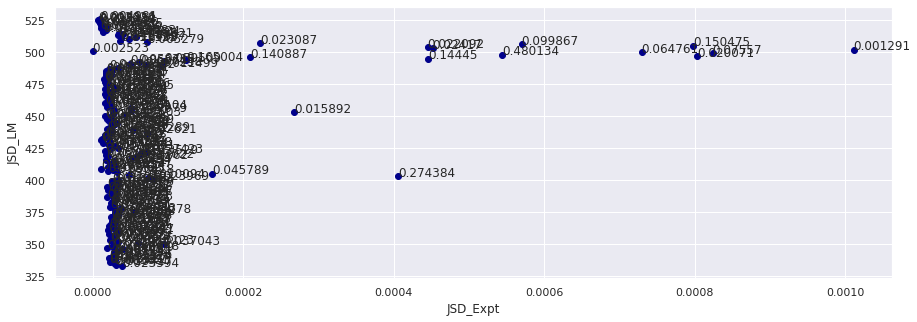

In [124]:
# open figure + axis
fig, ax = plt.subplots()
# plot
ax.scatter(x=combined_jsd_df['JSD'],y=combined_jsd_df['JSD_N501Y'],c='DarkBlue')
# set labels
ax.set_xlabel('JSD_Expt')
ax.set_ylabel('JSD_LM')

# annotate points in axis
for idx, row in combined_jsd_df.iterrows():
    ax.annotate(row['Index'], (row['JSD'], row['JSD_N501Y']) )
# force matplotlib to draw the graph
plt.show()


#sns.scatterplot(combined_jsd_df['Index'],combined_jsd_df['JSD_N501Y'])

In [125]:
#spearman correlation pt1
combined_jsd_df.corr(method='spearman')

scipy.stats.spearmanr(combined_jsd_df['JSD'],combined_jsd_df['JSD_N501Y'])

SpearmanrResult(correlation=-0.0974348017241025, pvalue=0.17651690632253975)

<AxesSubplot:>

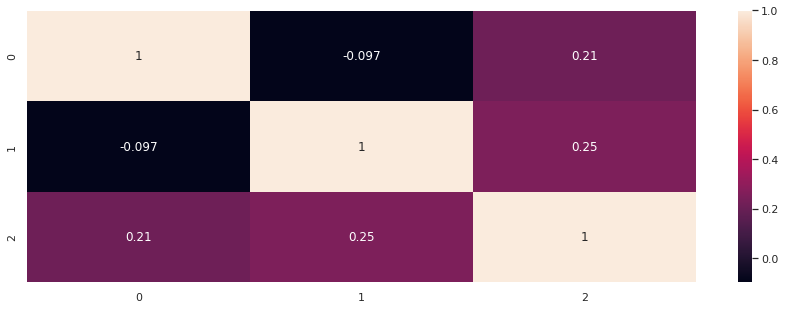

In [126]:
#spearman correlation attempt 2
corr_jsd,pval_corr_jsd = scipy.stats.spearmanr(jsd_notabs_df,jsd_N501Y[2:196]['JSD'])
sns.heatmap(corr_jsd, annot = True)


In [127]:
#Manually doing Spearman correlation to check lol

combined_jsd_df_ranks = combined_jsd_df.rank()
combined_jsd_df['JSD_rank'] = combined_jsd_df_ranks['JSD']
combined_jsd_df['JSD_N501Y_rank'] = combined_jsd_df_ranks['JSD_N501Y']
combined_jsd_df['d'] = combined_jsd_df['JSD_rank']-combined_jsd_df['JSD_N501Y_rank']
combined_jsd_df['d^2'] = combined_jsd_df['d']**2

rho = 1 - (6*(combined_jsd_df['d^2'].sum())/(len(combined_jsd_df)*(((len(combined_jsd_df))**2)-1)))
print(rho)
combined_jsd_df

-0.09743480172410246


,JSD,JSD_N501Y,Index,JSD_rank,JSD_N501Y_rank,d,d^2
0,0.000039,333,0.023594,153.0,1.0,152.0,23104.0
1,0.000031,334,0.010417,130.0,2.0,128.0,16384.0
2,0.000028,335,0.003853,108.0,3.0,105.0,11025.0
3,0.000022,336,0.008512,62.0,4.0,58.0,3364.0
4,0.000024,337,0.005127,71.0,5.0,66.0,4356.0
...,...,...,...,...,...,...,...
189,0.000011,522,0.020380,7.0,190.0,-183.0,33489.0
190,0.000009,523,0.027438,4.0,191.0,-187.0,34969.0
191,0.000009,524,0.015251,3.0,192.0,-189.0,35721.0
192,0.000007,525,0.002626,2.0,193.0,-191.0,36481.0


In [128]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(combined_jsd_df)

           JSD  JSD_N501Y  Index  JSD_rank  JSD_N501Y_rank      d      d^2
0    3.886e-05        333  0.024     153.0             1.0  152.0  23104.0
1    3.051e-05        334  0.010     130.0             2.0  128.0  16384.0
2    2.764e-05        335  0.004     108.0             3.0  105.0  11025.0
3    2.245e-05        336  0.009      62.0             4.0   58.0   3364.0
4    2.384e-05        337  0.005      71.0             5.0   66.0   4356.0
5    2.964e-05        338  0.014     123.0             6.0  117.0  13689.0
6    2.198e-05        339  0.014      59.0             7.0   52.0   2704.0
7    2.926e-05        340  0.008     120.0             8.0  112.0  12544.0
8    2.688e-05        341  0.017      99.0             9.0   90.0   8100.0
9    2.818e-05        342  0.036     111.0            10.0  101.0  10201.0
10   3.005e-05        343  0.008     127.0            11.0  116.0  13456.0
11   2.802e-05        344  0.008     110.0            12.0   98.0   9604.0
12   3.280e-05        345

In [129]:
jsd_N501Y

,site,JSD
201,331,0.061469
202,332,0.007132
203,333,0.023594
204,334,0.010417
205,335,0.003853
...,...,...
397,527,0.005388
398,528,0.004522
399,529,0.009693
400,530,0.018125


In [130]:
jsd_df = pd.Series(data=jsd_N501Y['Index'],index=jsd_N501Y['site'])
print(jsd_df)
result_N501Y.max()[jsd_df.nlargest(10).index]


site
331    0.010284
332    0.004576
333    0.012742
334    0.011142
335    0.005332
         ...   
527         NaN
528         NaN
529         NaN
530         NaN
531         NaN
Name: JSD, Length: 201, dtype: float64


site
368    0.290418
364    0.290356
375    0.292988
365    0.296946
366    0.292181
380    0.290356
376    0.290356
361    0.290356
369    0.291527
401    0.290356
dtype: float64

In [131]:
jsd_df

site
331    0.010284
332    0.004576
333    0.012742
334    0.011142
335    0.005332
         ...   
527         NaN
528         NaN
529         NaN
530         NaN
531         NaN
Name: JSD, Length: 201, dtype: float64